# Student Performance Data Set

## Data Set Information

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

## Goal
Our goal is to identify confounding variables in the dataset and select appropriate features to improve the model's performance.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [63]:
df = pd.read_csv('student-por.csv')

In [64]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [65]:
# Check for missing values
print(data.isnull().sum())

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


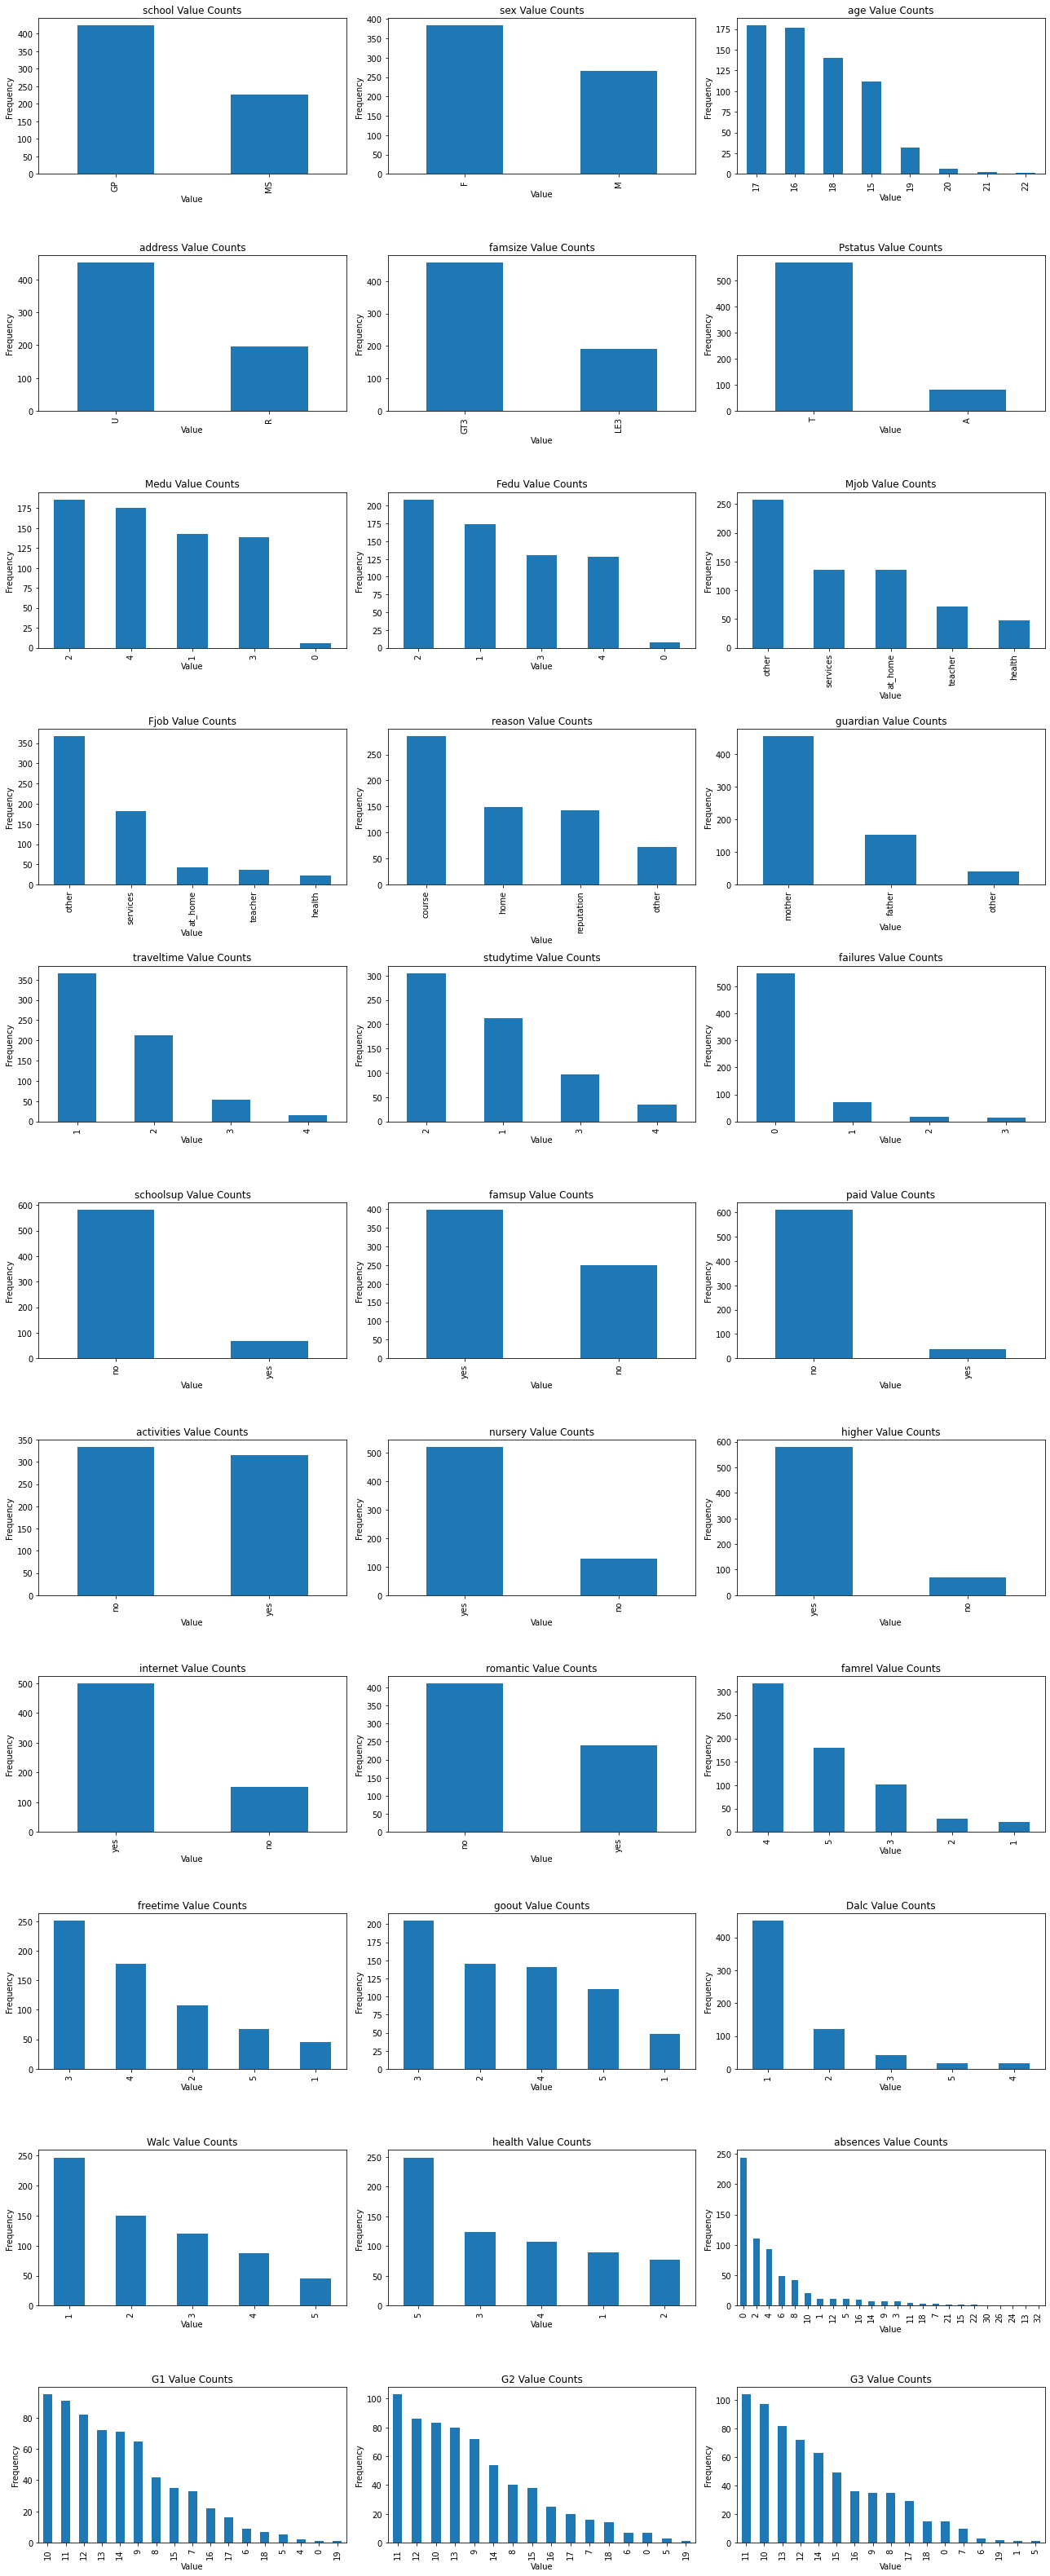

In [66]:
# The value distribution for each feature
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 6, n_rows * 4)) 

for i, column in enumerate(df.columns):
    value_counts = df[column].value_counts()
    plt.subplot(n_rows, n_cols, i + 1)
    value_counts.plot(kind='bar')
    plt.title(f'{column} Value Counts')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()  

plt.show()

## Linear regression without selecting features 

In [68]:
X = df.drop(columns=['G3'])
y = df['G3']

# one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)  

# Standardized feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit model using logistic regression
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

# Evaluation model
predictions = logit_model.predict(X_test)
print(classification_report(y_test, predictions,zero_division=0))

# coefficients of the model
coef_dict = {}
for coef, feat in zip(logit_model.coef_[0], X_encoded.columns):
    coef_dict[feat] = coef

coef_df = pd.DataFrame(list(coef_dict.items()), columns=['Feature', 'Coefficient'])
print(coef_df.to_string(index=False))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.40      0.29      0.33         7
           9       0.00      0.00      0.00         5
          10       0.29      0.29      0.29        17
          11       0.41      0.36      0.38        25
          12       0.21      0.19      0.20        16
          13       0.29      0.31      0.30        13
          14       0.20      0.17      0.18        12
          15       0.33      0.40      0.36        10
          16       0.12      0.22      0.16         9
          17       0.20      0.20      0.20         5
          18       0.33      0.14      0.20         7
          19       0.00      0.00      0.00         1

    accuracy                           0.26       130
   macro avg       0.22      0.20      0.21       130
weighted avg       0.28   

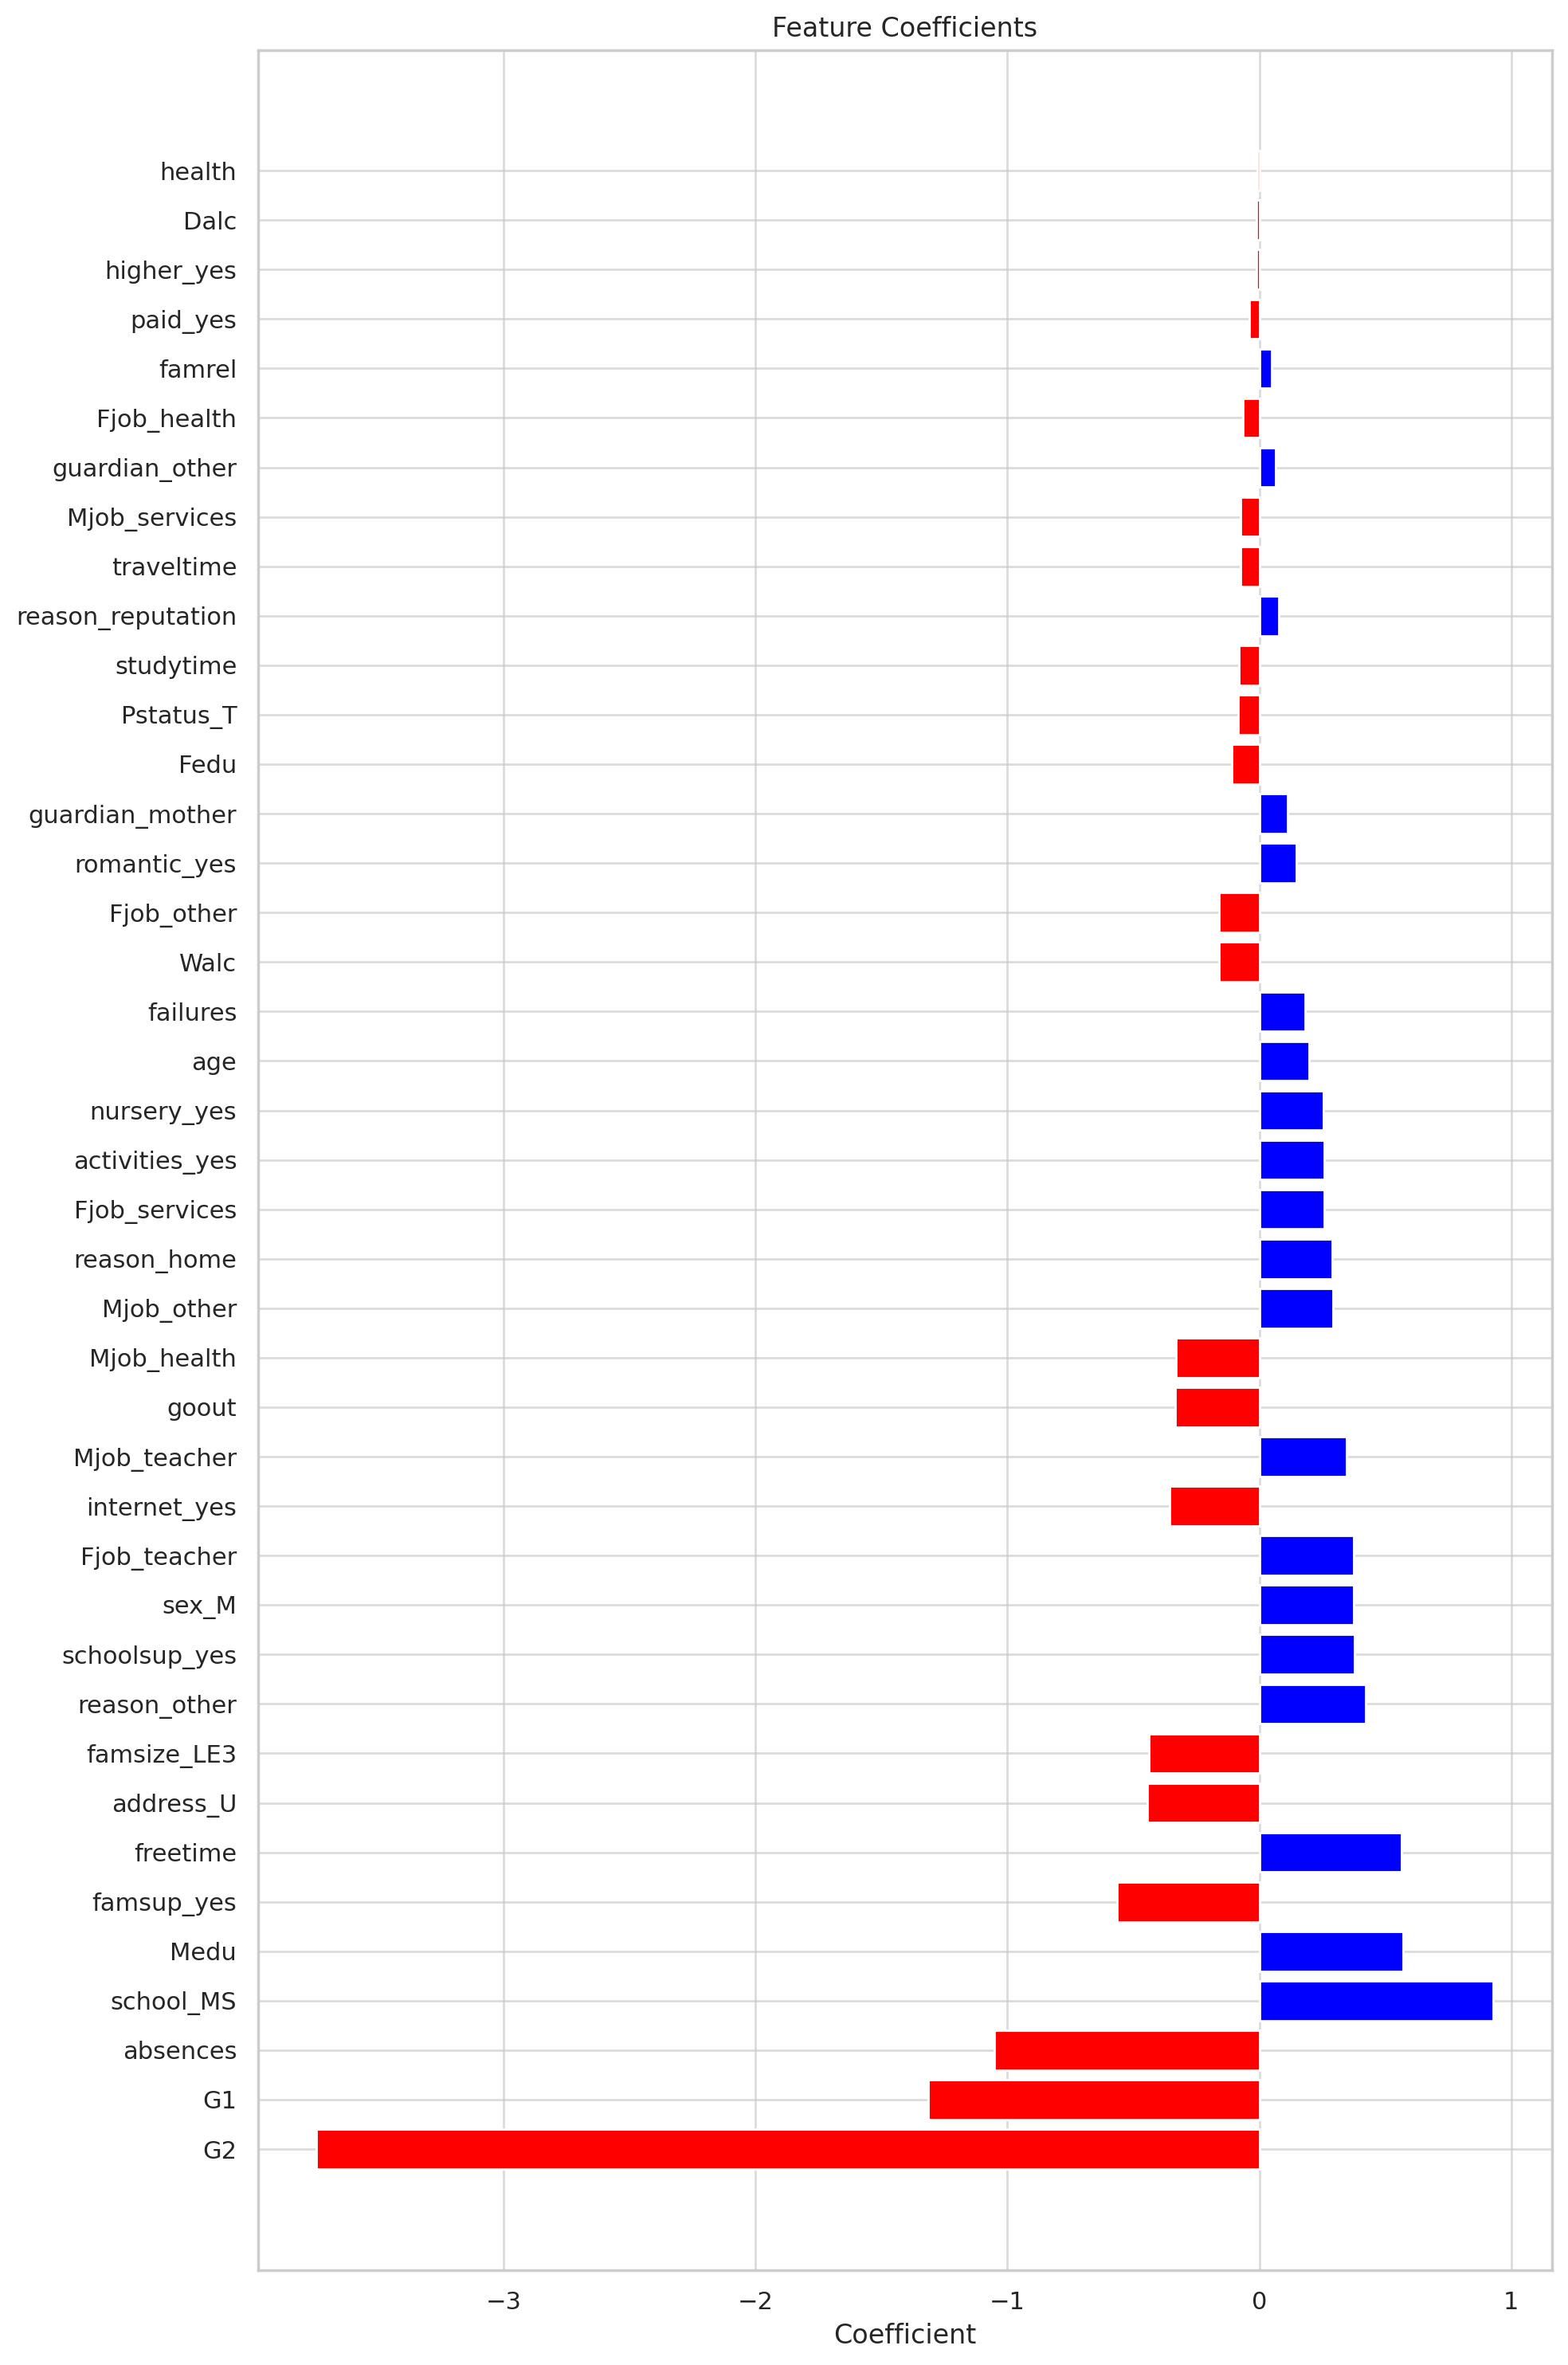

## Select features 

Based on the feature coefficients obtained above, first remove features with coefficients close to 0.

- `Pstatus_T`: -0.084590
- `studytime`: -0.081966
- `traveltime`: -0.076055
- `Mjob_services`: -0.075585
- `Fjob_health`: -0.064494
- `paid_yes`: -0.039034
- `higher_yes`: -0.011595
- `Dalc`: -0.009926
- `health`: -0.009071
- `famrel`: 0.047820
- `guardian_other`: 0.065370
- `reason_reputation`: 0.077798

## Matching

In [69]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.linear_model import LogisticRegression

# import data
df = pd.read_csv('student-por.csv')

# encoding
df['school'] = df['school'].apply(lambda x: 1 if x == 'GP' else 0)
df = pd.get_dummies(df, drop_first=True) 

# Selection covariate
covariates = [col for col in df.columns if col not in ['school', 'G3']]

# Calculated propensity score
log_reg = LogisticRegression()
df['propensity_score'] = log_reg.fit(df[covariates], df['school']).predict_proba(df[covariates])[:, 1]

# Treatment group and control group were separated
treatment_df = df[df['school'] == 1]
control_df = df[df['school'] == 0]

# Use NearestNeighbors to find the most recent propensity score for each treatment group member in the control group
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_df[['propensity_score']])
distances, indices = nn.kneighbors(treatment_df[['propensity_score']])

# Construct the matched data set
matched_control_df = control_df.iloc[indices.flatten()]
matched_df = pd.concat([treatment_df, matched_control_df])

matched_df.head()


/Users/zhiqingsu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,school,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,propensity_score
0,1,18,4,4,2,2,0,4,3,4,...,0,1,0,0,0,1,1,0,0,0.286502
1,1,17,1,1,1,2,0,5,3,3,...,0,0,1,0,0,0,1,1,0,0.544196
2,1,15,1,1,1,2,0,4,3,2,...,0,1,0,0,0,1,1,1,0,0.883907
3,1,15,4,2,1,3,0,3,2,2,...,0,0,1,0,1,1,1,1,1,0.928264
4,1,16,3,3,1,2,0,4,3,2,...,0,0,1,0,0,1,1,0,0,0.688070


In [30]:
import numpy as np
from scipy.stats import ttest_ind

def calculate_smd(groups, variable):
    mean_treatment = np.mean(groups[groups['school'] == 1][variable])
    mean_control = np.mean(groups[groups['school'] == 0][variable])
    pooled_sd = np.sqrt((np.std(groups[groups['school'] == 1][variable], ddof=1) ** 2 + 
                         np.std(groups[groups['school'] == 0][variable], ddof=1) ** 2) / 2)
    smd = (mean_treatment - mean_control) / pooled_sd
    return smd

# Calculate SMD for each covariate
smd_results = {var: calculate_smd(matched_df, var) for var in covariates}

# print SMD result
for var, smd in smd_results.items():
    print(f'{var}: SMD = {smd:.3f}')


age: SMD = 0.000
Medu: SMD = 0.039
Fedu: SMD = 0.015
traveltime: SMD = -0.194
studytime: SMD = -0.132
failures: SMD = -0.018
famrel: SMD = 0.049
freetime: SMD = 0.002
goout: SMD = -0.226
Dalc: SMD = 0.006
Walc: SMD = -0.074
health: SMD = -0.161
absences: SMD = 0.138
G1: SMD = -0.251
G2: SMD = -0.240
sex_M: SMD = -0.114
address_U: SMD = 0.012
famsize_LE3: SMD = -0.147
Pstatus_T: SMD = 0.150
Mjob_health: SMD = 0.172
Mjob_other: SMD = -0.010
Mjob_services: SMD = -0.086
Mjob_teacher: SMD = -0.027
Fjob_health: SMD = 0.209
Fjob_other: SMD = 0.033
Fjob_services: SMD = 0.044
Fjob_teacher: SMD = -0.204
reason_home: SMD = 0.093
reason_other: SMD = -0.028
reason_reputation: SMD = 0.005
guardian_mother: SMD = 0.031
guardian_other: SMD = -0.019
schoolsup_yes: SMD = 0.058
famsup_yes: SMD = 0.164
paid_yes: SMD = 0.052
activities_yes: SMD = -0.162
nursery_yes: SMD = 0.189
higher_yes: SMD = 0.009
internet_yes: SMD = 0.213
romantic_yes: SMD = 0.025


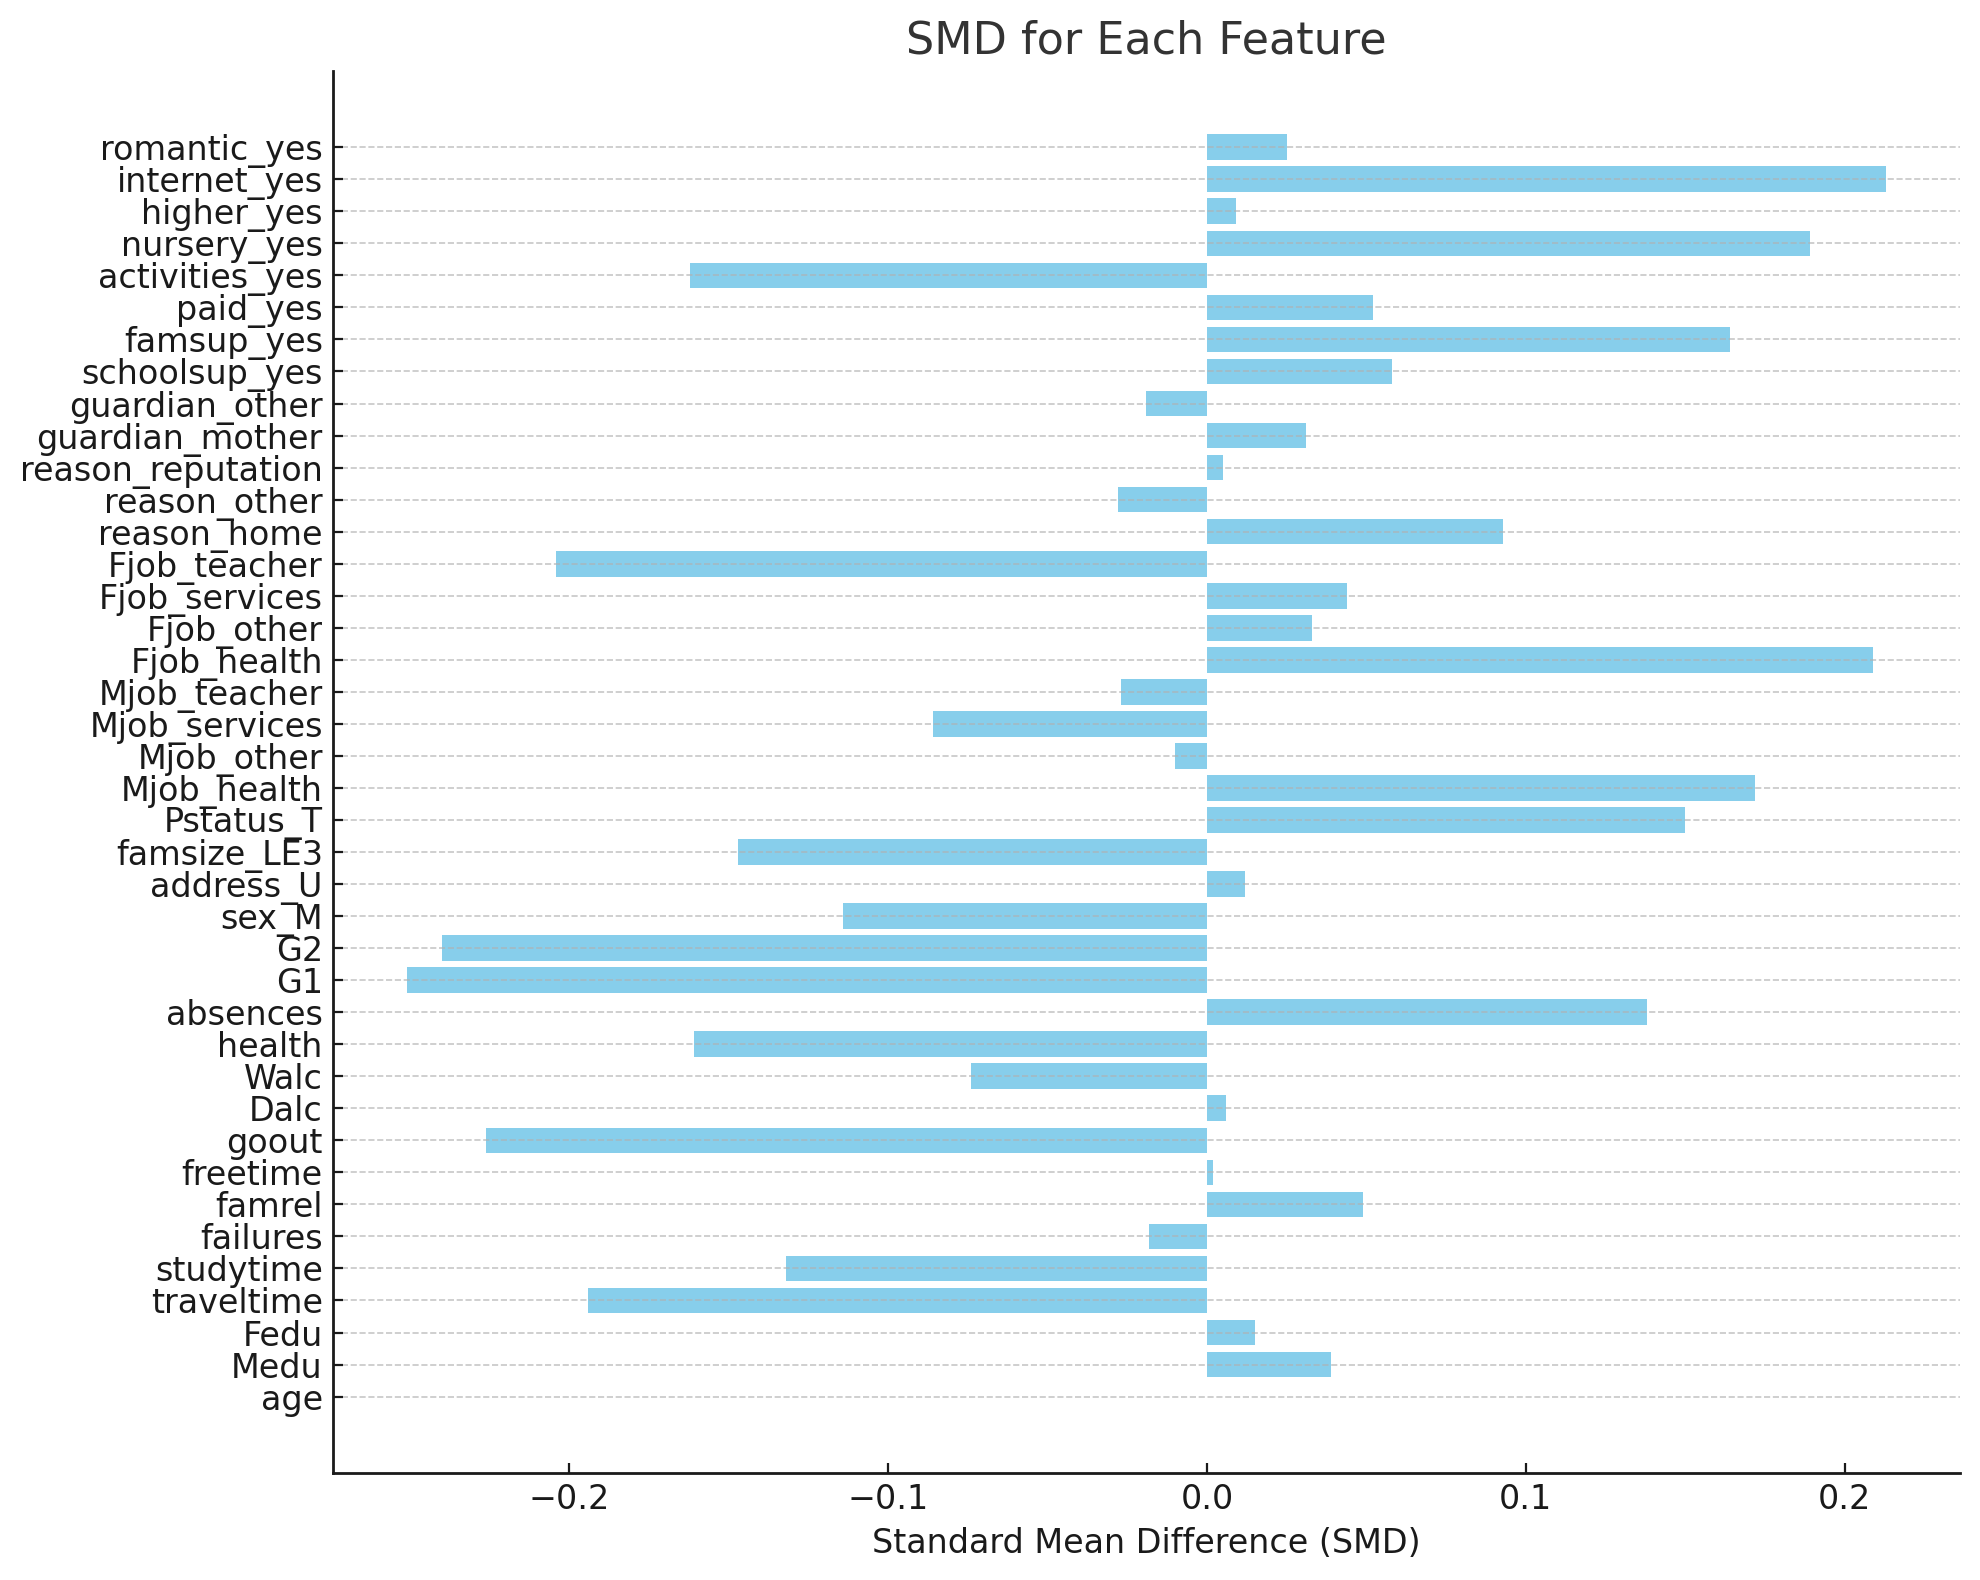

## Regression Adjustment

In [33]:
import pandas as pd
import statsmodels.api as sm

# Construct X and y of the regression model
X = df[['school'] + covariates]
X = sm.add_constant(X)  # Add constant term
y = df['G3']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print regression result
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     90.95
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          3.29e-230
Time:                        21:09:44   Log-Likelihood:                -1043.4
No. Observations:                 649   AIC:                             2171.
Df Residuals:                     607   BIC:                             2359.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4403      0.95

## Linear regression with selecting features 

In [70]:
df = pd.read_csv('student-por.csv')

features = ['failures','G1','G2','reason','Fjob']
selected_X = df[features]
selected_y = df['G3']

# one-hot encoding
selected_X_encoded = pd.get_dummies(selected_X, drop_first=True)  

# Standardized feature
scaler = StandardScaler()
selected_X_scaled = scaler.fit_transform(selected_X_encoded)

# split dataset
selected_X_train, selected_X_test, selected_y_train, selected_y_test = train_test_split(selected_X_scaled, selected_y, test_size=0.2, random_state=42)

selected_X_encoded.head()

# fit model using logistic regression
selected_logit_model = LogisticRegression(max_iter=1000)
selected_logit_model.fit(selected_X_train, selected_y_train)

# Evaluation model
selected_predictions = selected_logit_model.predict(selected_X_test)
print(classification_report(selected_y_test, selected_predictions,zero_division=0))

# coefficients of the model
selected_coef_dict = {}
for coef, feat in zip(selected_logit_model.coef_[0], selected_X_encoded.columns):
    selected_coef_dict[feat] = coef

selected_coef_df = pd.DataFrame(list(selected_coef_dict.items()), columns=['Feature', 'Coefficient'])
print(selected_coef_df.to_string(index=False))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.67      0.29      0.40         7
           9       0.00      0.00      0.00         5
          10       0.42      0.59      0.49        17
          11       0.61      0.56      0.58        25
          12       0.30      0.19      0.23        16
          13       0.27      0.31      0.29        13
          14       0.20      0.25      0.22        12
          15       0.83      0.50      0.62        10
          16       0.00      0.00      0.00         9
          17       0.19      0.80      0.31         5
          18       0.00      0.00      0.00         7
          19       0.00      0.00      0.00         1

    accuracy                           0.35       130
   macro avg       0.30      0.27      0.25       130
weighted avg       0.38   

In [72]:
print(classification_report(y_test, predictions,zero_division=0))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.40      0.29      0.33         7
           9       0.00      0.00      0.00         5
          10       0.29      0.29      0.29        17
          11       0.41      0.36      0.38        25
          12       0.21      0.19      0.20        16
          13       0.29      0.31      0.30        13
          14       0.20      0.17      0.18        12
          15       0.33      0.40      0.36        10
          16       0.12      0.22      0.16         9
          17       0.20      0.20      0.20         5
          18       0.33      0.14      0.20         7
          19       0.00      0.00      0.00         1

    accuracy                           0.26       130
   macro avg       0.22      0.20      0.21       130
weighted avg       0.28   

## Conclusion

By comparing the model performance before and after feature selection, we can observe several differences and trends:

### Model Accuracy
- The model accuracy increased from 26% to 35% after feature selection. This indicates that the model's overall predictive capability on the data has improved with feature selection.

### Precision, Recall, and F1-Score
- Across many categories, the model's precision, recall, and F1-scores showed various degrees of change after feature selection. Notably, for some categories (e.g., category 17), recall significantly improved, increasing from 20% to 80%, even though precision was low. This indicates a significant improvement in predictive performance for this category.
- However, some categories (e.g., categories 16 and 19) had precision, recall, and F1-scores of 0 after feature selection, possibly because the model could not correctly identify any positive samples for these categories. This could be due to sample imbalance or a decrease in the model's discriminative ability for these categories after feature selection.

### Macro Average and Weighted Average
- Both macro average and weighted average metrics improved after feature selection, especially the macro averages of precision, recall, and F1-score. This suggests that the model's overall performance across most categories has been enhanced after feature selection.

### Summary
Feature selection led to an improvement in overall model accuracy, indicating that removing less relevant or irrelevant features helps the model focus on features that significantly impact the target variable, thereby enhancing model prediction. Feature selection may also result in decreased performance for certain categories, necessitating further analysis of the model and the feature selection process to identify and address these issues.

It's noteworthy that while the model underperformed in certain categories, the overall increase in model accuracy underscores the positive impact of feature selection. For underperforming categories, further balancing of samples, feature engineering, or consideration of different models and algorithms might be necessary to improve model performance.

In practice, feature selection is an important and necessary step that not only can increase the accuracy of predictions but also reduce the time needed for model training and enhance interpretability. Overall, feature selection significantly impacts optimizing model performance and is worth trying and optimizing in different datasets and application scenarios.

# fetal health dataset

In [38]:
fh = pd.read_csv('fetal_health.csv')

In [39]:
fh.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


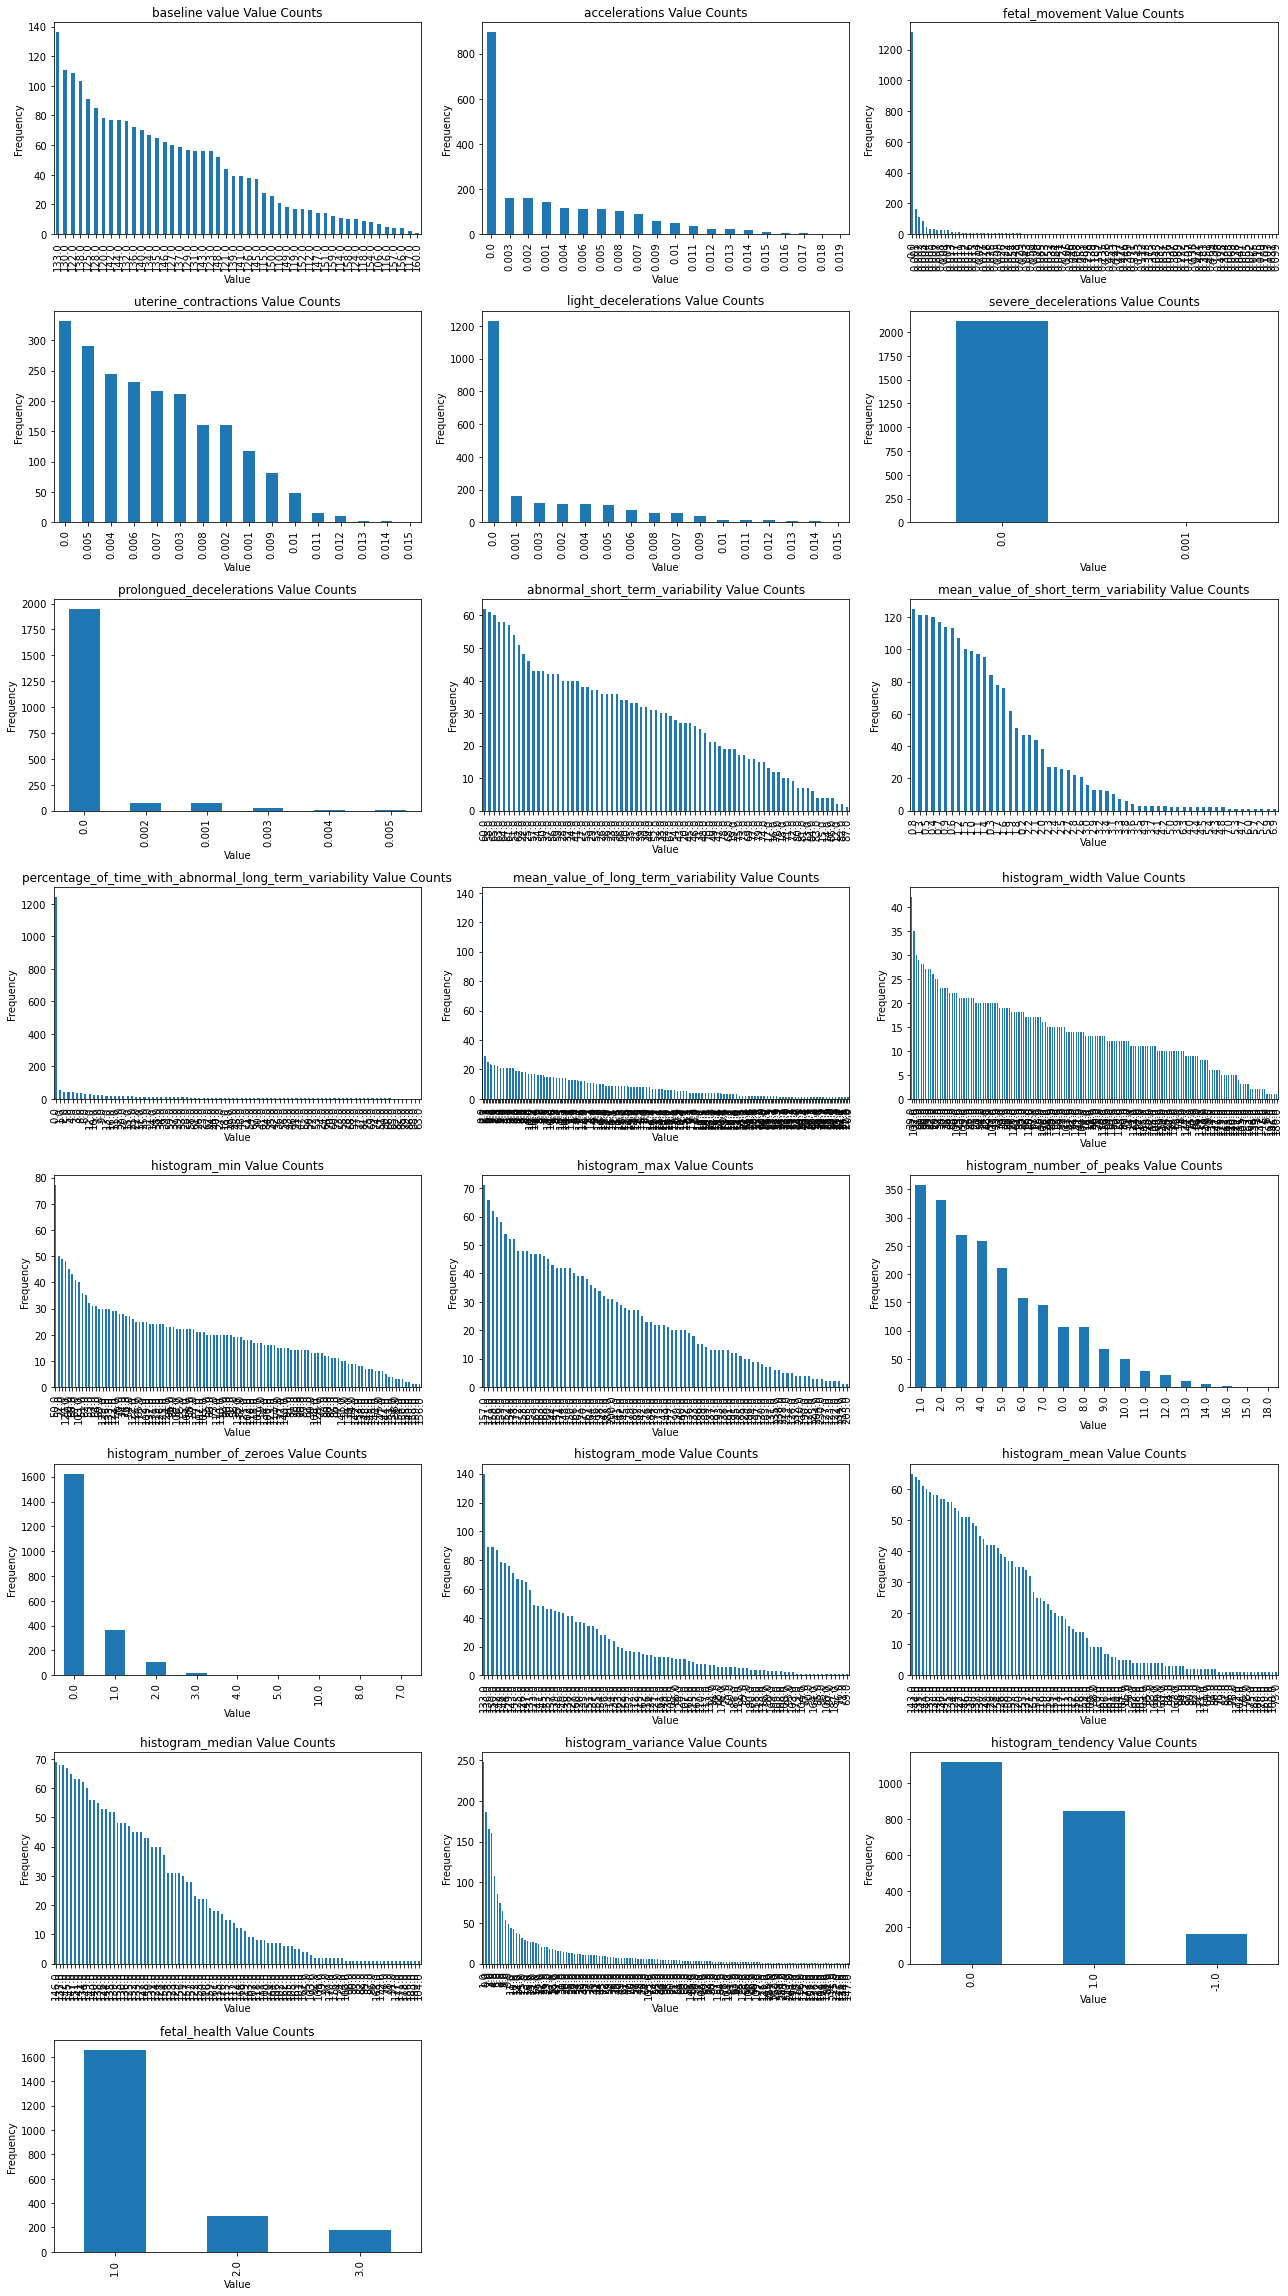

In [40]:
# The value distribution for each feature
n_cols = 3
n_rows = (len(fh.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 6, n_rows * 4)) 

for i, column in enumerate(fh.columns):
    value_counts = fh[column].value_counts()
    plt.subplot(n_rows, n_cols, i + 1)
    value_counts.plot(kind='bar')
    plt.title(f'{column} Value Counts')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()  

plt.show()

In [41]:
# Check for missing values
print(fh.isnull().sum())

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

## Linear regression without selecting features

In [45]:
X = fh.drop(columns=['fetal_health'])
y = fh['fetal_health']

# Standardized feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit model using logistic regression
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

# Evaluation model
predictions = logit_model.predict(X_test)
print(classification_report(y_test, predictions))

# coefficients of the model
coef_dict = {}
for coef, feat in zip(logit_model.coef_[0], X_encoded.columns):
    coef_dict[feat] = coef

coef_df = pd.DataFrame(list(coef_dict.items()), columns=['Feature', 'Coefficient'])
print(coef_df.to_string(index=False))

              precision    recall  f1-score   support

         1.0       0.94      0.93      0.94       333
         2.0       0.63      0.64      0.64        64
         3.0       0.73      0.76      0.75        29

    accuracy                           0.88       426
   macro avg       0.77      0.78      0.77       426
weighted avg       0.88      0.88      0.88       426

    Feature  Coefficient
        age    -0.335837
       Medu     1.994895
       Fedu    -0.422364
 traveltime     0.526995
  studytime     0.007978
   failures     0.052928
     famrel    -0.799070
   freetime    -1.449371
      goout     0.366719
       Dalc    -0.531089
       Walc    -0.189966
     health     0.019517
   absences    -0.345097
         G1    -0.526123
         G2     0.175984
  school_MS    -0.056431
      sex_M     0.654669
  address_U    -0.334539
famsize_LE3     0.216639
  Pstatus_T    -1.021541
Mjob_health    -0.168057


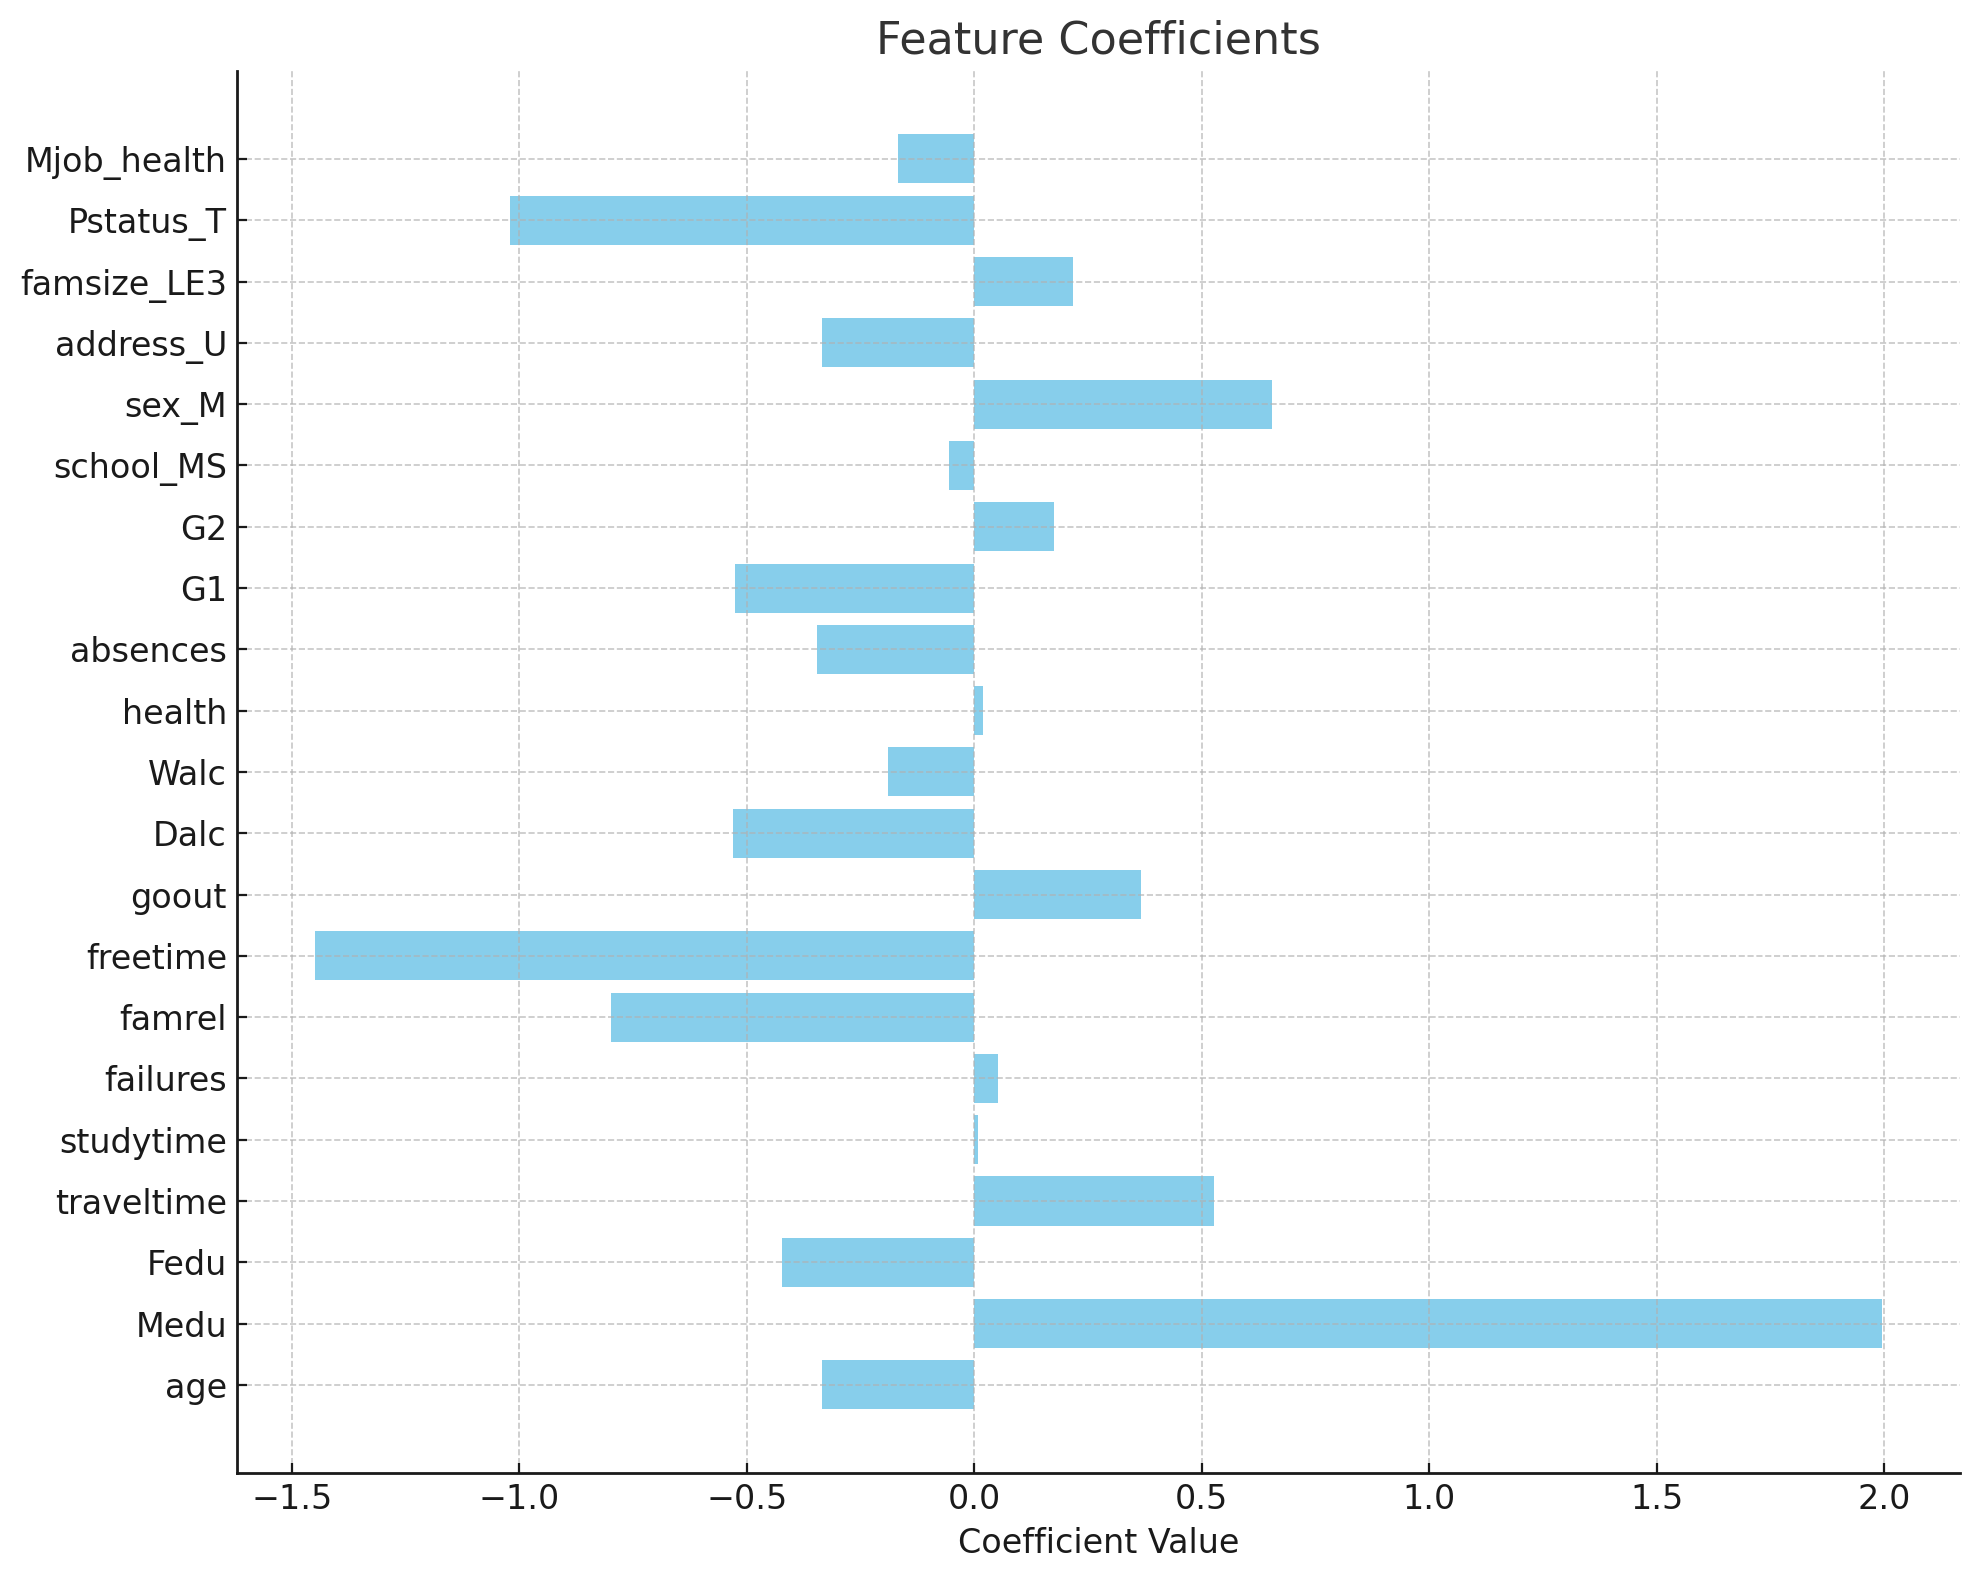

## Select featues

### Matching

In [51]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.linear_model import LogisticRegression

# import data
df = pd.read_csv('fetal_health.csv')

# Selection covariate
covariates = [col for col in df.columns if col not in ['fetal_health']]

# Calculated propensity score
log_reg = LogisticRegression()
df['propensity_score'] = log_reg.fit(df[covariates], df['fetal_health']).predict_proba(df[covariates])[:, 1]

# Treatment group and control group were separated
treatment_df = df[df['fetal_health'] == 1]
control_df = df[df['fetal_health'] == 2]

# Use NearestNeighbors to find the most recent propensity score for each treatment group member in the control group
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_df[['propensity_score']])
distances, indices = nn.kneighbors(treatment_df[['propensity_score']])

# Construct the matched data set
matched_control_df = control_df.iloc[indices.flatten()]
matched_df = pd.concat([treatment_df, matched_control_df])

matched_df.head()

def calculate_smd(groups, variable):
    mean_treatment = np.mean(groups[groups['fetal_health'] == 1][variable])
    mean_control = np.mean(groups[groups['fetal_health'] == 2][variable])
    pooled_sd = np.sqrt((np.std(groups[groups['fetal_health'] == 1][variable], ddof=1) ** 2 + 
                         np.std(groups[groups['fetal_health'] == 2][variable], ddof=1) ** 2) / 2)
    smd = (mean_treatment - mean_control) / pooled_sd
    return smd

# Calculate SMD for each covariate
smd_results = {var: calculate_smd(matched_df, var) for var in covariates}

# print SMD result
for var, smd in smd_results.items():
    print(f'{var}: SMD = {smd:.3f}')

baseline value: SMD = -0.977
accelerations: SMD = 1.092
fetal_movement: SMD = -0.366
uterine_contractions: SMD = 0.195
light_decelerations: SMD = 0.141
severe_decelerations: SMD = 0.035
prolongued_decelerations: SMD = -0.649
abnormal_short_term_variability: SMD = -0.197
mean_value_of_short_term_variability: SMD = 0.125
percentage_of_time_with_abnormal_long_term_variability: SMD = -0.166
mean_value_of_long_term_variability: SMD = -0.224
histogram_width: SMD = 0.090
histogram_min: SMD = -0.400
histogram_max: SMD = -0.526
histogram_number_of_peaks: SMD = 0.078
histogram_number_of_zeroes: SMD = -0.122
histogram_mode: SMD = -0.611
histogram_mean: SMD = -0.635
histogram_median: SMD = -0.693
histogram_variance: SMD = -0.060
histogram_tendency: SMD = 0.090


/Users/zhiqingsu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.linear_model import LogisticRegression

# import data
df = pd.read_csv('fetal_health.csv')

# Selection covariate
covariates = [col for col in df.columns if col not in ['fetal_health']]

# Calculated propensity score
log_reg = LogisticRegression()
df['propensity_score'] = log_reg.fit(df[covariates], df['fetal_health']).predict_proba(df[covariates])[:, 1]

# Treatment group and control group were separated
treatment_df = df[df['fetal_health'] == 1]
control_df = df[df['fetal_health'] == 3]

# Use NearestNeighbors to find the most recent propensity score for each treatment group member in the control group
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_df[['propensity_score']])
distances, indices = nn.kneighbors(treatment_df[['propensity_score']])

# Construct the matched data set
matched_control_df = control_df.iloc[indices.flatten()]
matched_df = pd.concat([treatment_df, matched_control_df])

matched_df.head()

def calculate_smd(groups, variable):
    mean_treatment = np.mean(groups[groups['fetal_health'] == 1][variable])
    mean_control = np.mean(groups[groups['fetal_health'] == 3][variable])
    pooled_sd = np.sqrt((np.std(groups[groups['fetal_health'] == 1][variable], ddof=1) ** 2 + 
                         np.std(groups[groups['fetal_health'] == 3][variable], ddof=1) ** 2) / 2)
    smd = (mean_treatment - mean_control) / pooled_sd
    return smd

# Calculate SMD for each covariate
smd_results = {var: calculate_smd(matched_df, var) for var in covariates}

# print SMD result
for var, smd in smd_results.items():
    print(f'{var}: SMD = {smd:.3f}')

baseline value: SMD = 0.393
accelerations: SMD = 1.351
fetal_movement: SMD = -0.866
uterine_contractions: SMD = 0.696
light_decelerations: SMD = -0.675
severe_decelerations: SMD = -0.157
prolongued_decelerations: SMD = -1.528
abnormal_short_term_variability: SMD = -1.018
mean_value_of_short_term_variability: SMD = 0.093
percentage_of_time_with_abnormal_long_term_variability: SMD = -0.323
mean_value_of_long_term_variability: SMD = 0.652
histogram_width: SMD = 0.033
histogram_min: SMD = 0.385
histogram_max: SMD = 0.677
histogram_number_of_peaks: SMD = -0.386
histogram_number_of_zeroes: SMD = 0.132
histogram_mode: SMD = 1.426
histogram_mean: SMD = 1.586
histogram_median: SMD = 1.445
histogram_variance: SMD = -0.855
histogram_tendency: SMD = 0.032


/Users/zhiqingsu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Regression Adjustment

In [49]:
import statsmodels.api as sm

df = pd.read_csv('fetal_health.csv')

# Construct X and y of the regression model
X = df.drop(columns=['fetal_health'])
X = sm.add_constant(X)  # Add constant term
y = df['fetal_health']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print regression result
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           fetal_health   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     162.8
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:47:42   Log-Likelihood:                -986.93
No. Observations:                2126   AIC:                             2016.
Df Residuals:                    2105   BIC:                             2135.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

## Linear Regression with selecting features

In [61]:
df = pd.read_csv('fetal_health.csv')

features = ['baseline value','uterine_contractions','prolongued_decelerations','abnormal_short_term_variability','percentage_of_time_with_abnormal_long_term_variability','mean_value_of_long_term_variability','histogram_min','histogram_max','histogram_mode','histogram_median','histogram_variance','histogram_tendency']
selected_X = df[features]
selected_y = df['fetal_health']

# Standardized feature
scaler = StandardScaler()
selected_X_scaled = scaler.fit_transform(selected_X)

# split dataset
selected_X_train, selected_X_test, selected_y_train, selected_y_test = train_test_split(selected_X_scaled, selected_y, test_size=0.2, random_state=42)

# fit model using logistic regression
selected_logit_model = LogisticRegression(max_iter=1000)
selected_logit_model.fit(selected_X_train, selected_y_train)

# Evaluation model
selected_predictions = selected_logit_model.predict(selected_X_test)
print(classification_report(selected_y_test, selected_predictions))

# coefficients of the model
selected_coef_dict = {}
for coef, feat in zip(selected_logit_model.coef_[0], selected_X.columns):
    selected_coef_dict[feat] = coef

selected_coef_df = pd.DataFrame(list(selected_coef_dict.items()), columns=['Feature', 'Coefficient'])
print(selected_coef_df.to_string(index=False))

              precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       333
         2.0       0.71      0.58      0.64        64
         3.0       0.81      0.76      0.79        29

    accuracy                           0.89       426
   macro avg       0.82      0.77      0.79       426
weighted avg       0.89      0.89      0.89       426

                                               Feature  Coefficient
                                        baseline value    -1.083613
                                  uterine_contractions     0.550425
                              prolongued_decelerations    -0.895911
                       abnormal_short_term_variability    -1.395370
percentage_of_time_with_abnormal_long_term_variability    -0.759689
                   mean_value_of_long_term_variability    -0.414480
                                         histogram_min    -0.520712
                                         histogram_max    -0.223859
       

In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.93      0.94       333
         2.0       0.63      0.64      0.64        64
         3.0       0.73      0.76      0.75        29

    accuracy                           0.88       426
   macro avg       0.77      0.78      0.77       426
weighted avg       0.88      0.88      0.88       426



## Conclusion

Comparing the performance metrics before and after feature selection reveals several key insights about the impact of feature selection on model performance for predicting fetal health:

### Model Performance Overview

- **Accuracy**: There's a slight improvement in overall accuracy after feature selection, increasing from 88% to 89%. This indicates that the model with selected features is slightly more accurate in predicting fetal health across all classes.

- **Precision**: 
  - For Class 1 (Normal), precision slightly decreased from 94% to 93%.
  - For Class 2 (Suspect), there's a notable improvement in precision, from 63% to 71%.
  - For Class 3 (Pathological), precision improved from 73% to 81%.

- **Recall**:
  - Recall for Class 1 increased from 93% to 96%.
  - Recall for Class 2 decreased from 64% to 58%.
  - Recall for Class 3 slightly decreased from 76% to 76%.

- **F1-Score**:
  - The F1-score for Class 1 slightly increased, indicating a balanced improvement between precision and recall.
  - The F1-score for Class 2 decreased, reflecting a trade-off between increased precision and decreased recall.
  - The F1-score for Class 3 improved, suggesting that the model's overall predictive performance for pathological cases has enhanced.

### Summary

The comparison of model performance before and after feature selection highlights the benefits of feature selection in enhancing the model's predictive accuracy and performance across different classes. Specifically, the improvements in precision for Classes 2 and 3 after feature selection demonstrate that the model has become more adept at correctly identifying suspect and pathological cases, albeit with some trade-offs in recall for Class 2. 

The slight decrease in recall for Class 3, along with the decrease in F1-score for Class 2, suggests a complexity in balancing sensitivity and specificity across different classes, which is a common challenge in multi-class classification problems.

Overall, the feature selection process has contributed to a more accurate and, potentially, a more interpretable model by focusing on the most relevant features. This result underlines the importance of feature selection in modeling, especially in applications with multiple classes and potentially many input features. It highlights that careful feature selection can lead to improvements in model performance, not just in terms of accuracy but also in precision and recall for specific classes, which are crucial for understanding and addressing specific predictive challenges.